In [4]:
import numpy as np
import cv2 as cv
import cv2
from skimage import io
from google.colab.patches import cv2_imshow
import imutils
# import pyimagesearcha
# from pyimagesearch.transform import four_point_transform

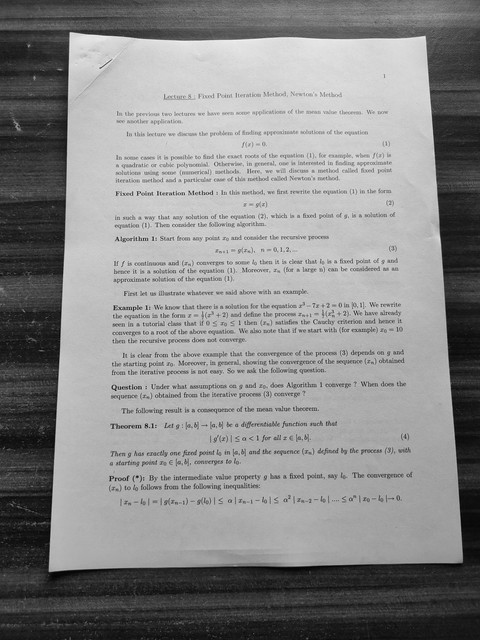

In [5]:
url = "https://i.ibb.co/BT4sXh6/IMG20210609174628.jpg"
image = io.imread(url)
# image=cv2.resize(image,(432*5,576*5),0.1,0.1,interpolation=cv2.INTER_AREA)
image=cv2.cvtColor(image, cv.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

In [6]:
# corners=cv2.goodFeaturesToTrack(gray,5,0.001,700)
# print(corners)
# imge=image
# corners = np.int0(corners)
# for corner in corners:
#   x,y=corner.ravel()
#   cv2.circle(imge,(x,y),6,255,-1)
# cv2_imshow(imge)

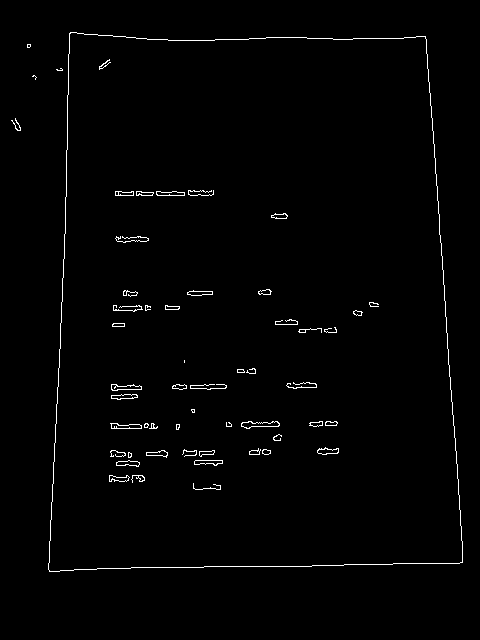

In [7]:
gray=cv2.GaussianBlur(gray,(5,5),0)
canny_result=cv2.Canny(gray,100,200)
cv2_imshow(canny_result)

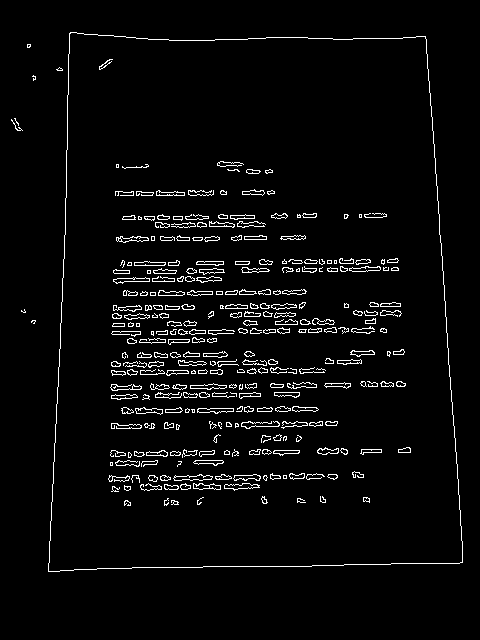

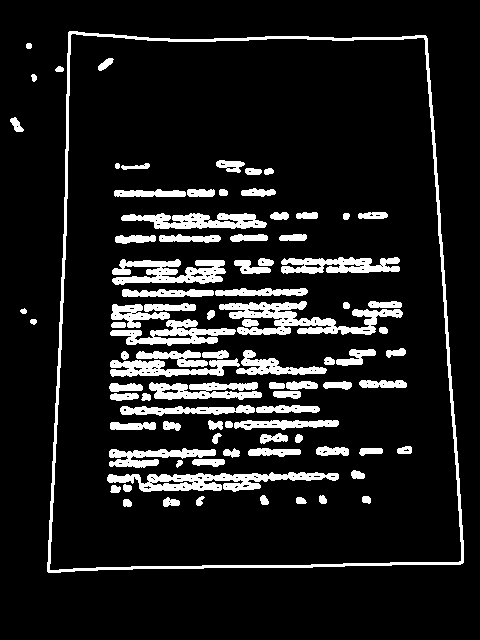

[[[27 45]]

 [[28 44]]

 [[29 44]]

 [[30 45]]

 [[28 47]]

 [[27 46]]]


In [8]:
def thresh_callback(image, val):
  threshold = val
  canny_output = cv.Canny(image, threshold, threshold*2)
  contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  drawing = np.zeros((image.shape[0], image.shape[1], 3), dtype = np.uint8)
  for i in range(len(contours)):
    color = (255,255,255)
    cv.drawContours(drawing, contours, i, color, 2, cv.LINE_8, hierarchy, 0)

  cv2_imshow(canny_output)
  cv2_imshow(drawing)

  return contours

src_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
src_gray = cv.blur(src_gray, (3,3))

contours = thresh_callback(src_gray, 100)
print(contours[8])

[[[ 70  32]]

 [[ 48 571]]

 [[462 562]]

 [[425  36]]]
STEP 2: Find contours of paper


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


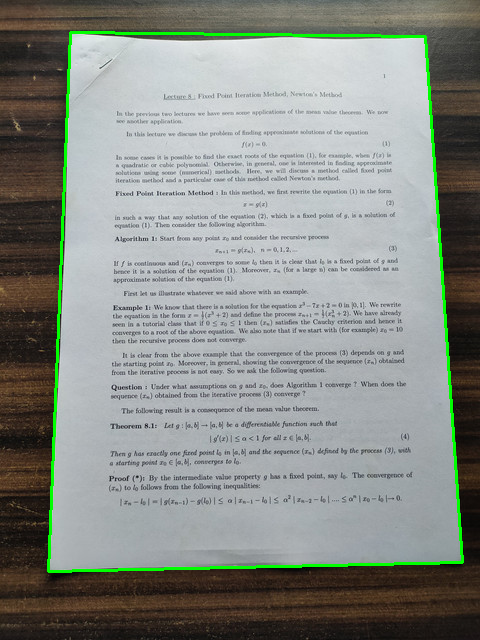

In [9]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cntrs = np.array(contours)
contours = sorted(contours, key = cv.contourArea, reverse = True)[:5]
# loop over the contours
for c in contours:
 	# approximate the contour
  peri = cv.arcLength(c, True)
  approx = cv.approxPolyDP(c, 0.02 * peri, True)
  print(approx)
	#
	# if our approximated contour has four points, then we
	# can assume that we have found our screen
  if len(approx)>=4:
    screenCnt = approx
    break
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
cv2_imshow(image)


In [10]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [11]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

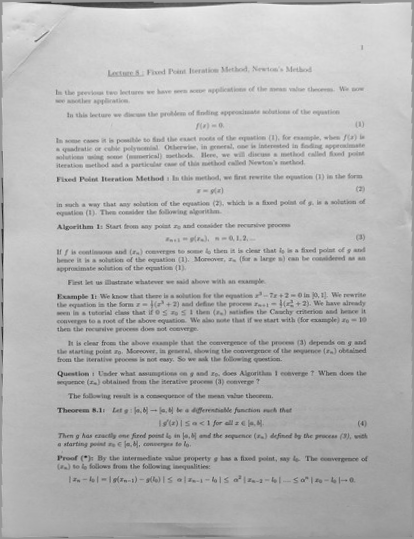

(539, 414)


In [12]:
warped=four_point_transform(image,screenCnt.reshape(4,2))
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
cv2_imshow(warped)
wn=warped
print(warped.shape)

In [13]:
def normalize(image):
  image = np.where(image>255, 0, image) 
  cv.normalize(image, image, 0, 255, cv.NORM_MINMAX)
  return image

223146


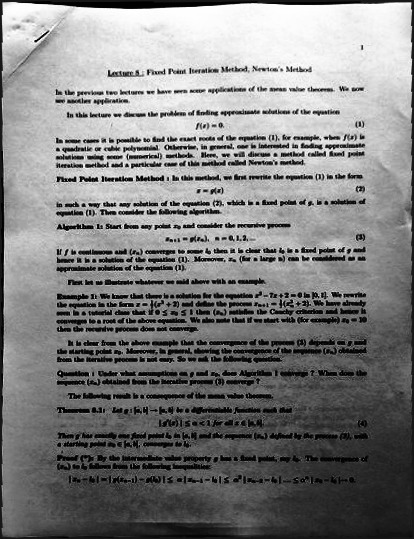

In [14]:
pixel_count=wn.size
print(pixel_count)
hist_np,bins=np.histogram(wn.flatten(),256,[0,256])
pmf_dist_np=hist_np/pixel_count

cdf=pmf_dist_np.cumsum()

cdf_normalized=cdf*float(pmf_dist_np.max())

cdf_m=np.ma.masked_equal(hist_np.cumsum(),0)
cdf_m=(cdf_m-cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf=np.ma.filled(cdf_m,0).astype('uint8')

imge=cdf[wn]
cv2_imshow(imge)
warped=imge

Enter the value to be increased in 10/20/30/...20


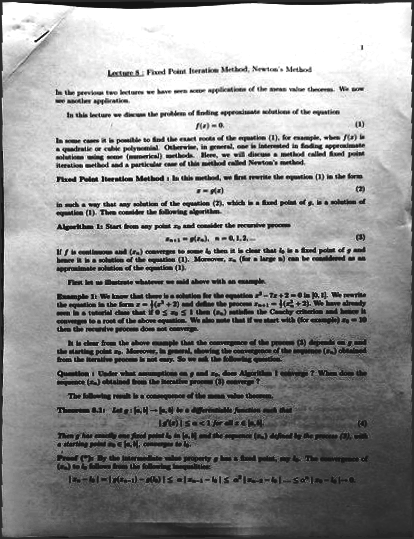

In [15]:
# print("Enter the value to be increased in 10/20/30/...")
a=int(input("Enter the value to be increased in 10/20/30/..."))
# a=10
# print(warped.shape[1])
warped_new=warped+a 
warped_new=np.where(warped_new<a,255,warped_new)
cv2_imshow(warped_new)
wn=warped_new
# image=cv2.resize(warped_new,(432*5,576*5),0.1,0.1,interpolation=cv2.INTER_AREA)
# cv2_imshow(image)
# img=np.ones([250,250])*270
# cv2_imshow(img)

Enter the clockwise rotation angle  90


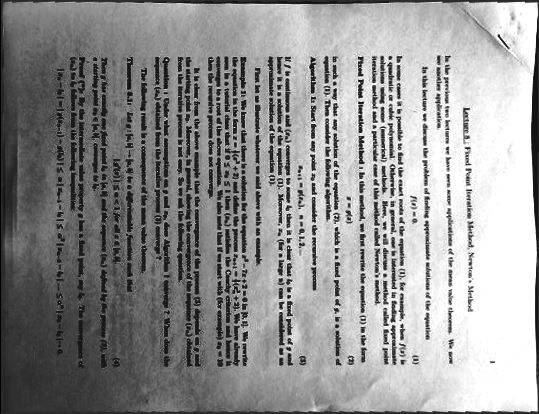

In [18]:
(h, w) = wn.shape[:2]
(cX, cY) = (w // 2, h // 2)
degree=int(input("Enter the clockwise rotation angle  "))
# M = cv2.getRotationMatrix2D((cX, cY), 45, 0.5)
# rotated = cv2.warpAffine(wn, M, (w, h))
rotated = imutils.rotate_bound(wn, degree)
cv2_imshow(rotated)